# Neural Machine Translation

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-11.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a Neural Machine Translation model to translate human-readable dates into machine-readable dates.

[Neural Machine Translation (NMT)](https://en.wikipedia.org/wiki/Neural_machine_translation) is a deep learning approach to machine translation that uses artificial neural networks to predict the likelihood of a sequence of words in the target language, given a sequence of words in the source language.

For our case, the network will input a date written in a variety of possible formats (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987") and translate them into standardized, machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24"). The model will be trained on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates and learn to output dates in the common machine-readable format YYYY-MM-DD.

## Import libraries

In [1]:
# !pip install faker babel
from faker import Faker
from babel.dates import format_date
from datetime import datetime
import random
from tqdm import tqdm
import numpy as np
from keras import utils, layers, activations, Model, callbacks, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-01-04 14:23:30.601927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736022210.624336  245169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736022210.631169  245169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 14:23:30.653713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create the dataset

In [2]:
def load_date():
    """
        Loads some fake dates.
        Returns a tuple containing human readable string, machine readable string, and date object.
    """

    fake = Faker()
    dt = fake.date_object()
    
    # Define format of the data we would like to generate
    FORMATS = ['short', 'medium', 'long', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full',
               'd MMM YYY', 'd MMMM YYY', 'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY', 'd MM YY', 'd MMMM YYY',
               'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']
                
    try:
        human_readable = format_date(dt, format=random.choice(FORMATS), locale='en_US')
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        machine_readable = dt.isoformat()       
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(n):
    """
        Loads a dataset with "n" examples and vocabularies, where "n" is the number of examples to generate.
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    
    for _ in tqdm(range(n)):
        h, m, _ = load_date()

        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k, v in inv_machine.items()}

    return dataset, human, machine, inv_machine

In [3]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(n=10000)
dataset[:10]

100%|██████████| 10000/10000 [00:12<00:00, 779.72it/s]


[('12.06.84', '1984-06-12'),
 ('21 mar 1988', '1988-03-21'),
 ('10 04 09', '2009-04-10'),
 ('05 feb 2007', '2007-02-05'),
 ('tuesday march 25 1986', '1986-03-25'),
 ('saturday november 9 2013', '2013-11-09'),
 ('april 27 2003', '2003-04-27'),
 ('november 9 2022', '2022-11-09'),
 ('31 08 09', '2009-08-31'),
 ('friday october 5 1973', '1973-10-05')]

- `dataset`: A list of tuples of (human readable date, machine readable date).
- `human_vocab`: A python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: A python dictionary mapping all characters used in machine readable dates to an integer-valued index.
- `inv_machine_vocab`: The inverse dictionary of machine_vocab, mapping from indices back to characters.

## Preprocess the dataset

In [4]:
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab".
    
    Arguments:
    string -- Input string, e.g. 'Wed 10 Jul 2007'
    length -- The number of time steps, it determines if the output will be padded or cut
    vocab -- Vocabulary, dictionary used to index every character of the "string"
    
    Returns:
    rep -- List of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    # Make lower to standardize
    string = string.lower()
    string = string.replace(',', '')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    return rep

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: utils.to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: utils.to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

- `X`: A processed version of the human readable dates in the training set.
    - Each character in `X` is replaced by an index (integer) mapped to the character using `human_vocab`.
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >).
    - X.shape = (m, Tx) where m is the number of training examples in a batch.
- `Y`: A processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`.
    - Y.shape = (m, Ty).
- `Xoh`: One-hot version of `X`.
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0).
    - Xoh.shape = (m, Tx, len(human_vocab)).
- `Yoh`: One-hot version of `Y`.
    - Each index in `Y` is converted to the one-hot representation.
    - Yoh.shape = (m, Ty, len(machine_vocab)).
    - len(machine_vocab) = 11 since there are 10 numeric digits (0 to 9) and the `-` symbol.

## Split the dataset into train, validation and test subsets

In [5]:
Tx = 30 # Assume Tx is the maximum length of the human readable date
Ty = 10 # "YYYY-MM-DD" is 10 characters long
dataset_train = dataset[:8000]
dataset_validation = dataset[8000:9000]
dataset_test = dataset[9000:]

print("Number of training samples:", len(dataset_train))
print("Number of validation samples:", len(dataset_validation))
print("Number of test samples:", len(dataset_test))

Number of training samples: 8000
Number of validation samples: 1000
Number of test samples: 1000


In [6]:
X_train, Y_train, Xoh_train, Yoh_train = preprocess_data(dataset_train, human_vocab, machine_vocab, Tx, Ty)
X_validation, Y_validation, Xoh_validation, Yoh_validation = preprocess_data(dataset_validation, human_vocab, machine_vocab, Tx, Ty)
X_test, Y_test, Xoh_test, Yoh_test = preprocess_data(dataset_test, human_vocab, machine_vocab, Tx, Ty)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Xoh_train shape:", Xoh_train.shape)
print("Yoh_train shape:", Yoh_train.shape)

print("\nSource date:", dataset_train[0][0])
print("Target date:", dataset_train[0][1])

print("\nSource after preprocessing (indices):", X_train[0])
print("Target after preprocessing (indices):", Y_train[0])

print("\nSource after preprocessing (one-hot):\n", Xoh_train[0])
print("Target after preprocessing (one-hot):\n", Yoh_train[0])

X_train shape: (8000, 30)
Y_train shape: (8000, 10)
Xoh_train shape: (8000, 30, 37)
Yoh_train shape: (8000, 10, 11)

Source date: 12.06.84
Target date: 1984-06-12

Source after preprocessing (indices): [ 4  5  1  3  9  1 11  7 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  5  0  1  7  0  2  3]

Source after preprocessing (one-hot):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot):
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## Build a Neural Machine Translation network with attention

The [attention mechanism](https://arxiv.org/pdf/1508.04025v5) tells a NMT model where it should pay attention to at any step.

In [7]:
def softmax(x, axis=1):
    """Custom softmax activation function.
    # Arguments
        x: Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """

    ndim = x.shape.rank

    if ndim == 2:
        return activations.softmax(x)
    elif ndim > 2:
        e = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
        s = tf.reduce_sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D!')

Define shared layers as global variables:

In [8]:
repeator = layers.RepeatVector(Tx) # Repeat the input n times
concatenator = layers.Concatenate(axis=-1) # Layer that concatenates a list of inputs
densor1 = layers.Dense(10, activation="tanh")
densor2 = layers.Dense(1, activation="relu")
activator = layers.Activation(softmax, name='attention_weights') # Use a custom softmax(axis=1)
dotor = layers.Dot(axes=1) # Layer that computes a dot product between samples in two tensors

In [9]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- Hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- Previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- Context vector, input of the next (post-attention) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that it can  be concatenated with all hidden states "a"
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies"
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies"
    energies = densor2(e)
    # Use activator on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
    
    return context

In [10]:
n_a = 32 # Number of units for the pre-attention, bi-directional LSTM's hidden state "a"
n_s = 64 # Number of units for the post-attention LSTM's hidden state "s"

# This is the post attention LSTM cell
post_activation_LSTM_cell = layers.LSTM(n_s, return_state=True)
output_layer = layers.Dense(len(machine_vocab), activation=softmax)

# Define the inputs of the model with a shape (Tx,)
inputs = layers.Input(shape=(Tx, len(human_vocab)))

# Define s0 (initial hidden state) and c0 (initial cell state)
# for the decoder LSTM with shape (n_s,)
s0 = layers.Input(shape=(n_s,))
c0 = layers.Input(shape=(n_s,))
s, c = s0, c0

# Initialize empty list of outputs
outputs = []

# Define the pre-attention Bi-LSTM
a = layers.Bidirectional(layers.LSTM(n_a, return_sequences=True))(inputs)

# Iterate for Ty steps
for t in range(Ty):
    # Perform one step of the attention mechanism to get back the context vector at step t
    context = one_step_attention(a, s)
    
    # Apply the post-attention LSTM cell to the "context" vector
    s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
    
    # Apply Dense layer to the hidden state output of the post-attention LSTM
    output = output_layer(s)
    
    # Append "output" to the "outputs" list
    outputs.append(output)

# Create model instance taking three inputs and returning the list of outputs
model = Model(inputs=[inputs, s0, c0], outputs=outputs)

model.summary()

I0000 00:00:1736022227.621982  245169 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1644 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ input_layer_1[0]… │
│ (RepeatVector)      │                   │            │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0],       │
│                     │                   │            │ lstm[3][0],       │
│                     │                   │            │ lstm[4][0],       │
│                     │                   │            │ lstm[5][0],       │
│                     │                   │            │ lstm[6][0],       │
│                     │                   │            │ lstm[7][0],       │
│                     │                   │            │ lstm[8][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

## Create a custom callback

In [11]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - loss: {logs['loss']:.4f} - val_loss: {logs['val_loss']:.4f}")

## Compile and train the model

In [12]:
model.compile(optimizer=optimizers.Adam(1e-2), loss='categorical_crossentropy')

epochs = 100
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=int(epochs/10), verbose=1)

# Initialize s0 and c0
s0_train = np.zeros((Xoh_train.shape[0], n_s))
c0_train = np.zeros((Xoh_train.shape[0], n_s))
s0_validation = np.zeros((Xoh_validation.shape[0], n_s))
c0_validation = np.zeros((Xoh_validation.shape[0], n_s))
Xoh_train_ = [Xoh_train, s0_train, c0_train]
Yoh_train_ = list(Yoh_train.swapaxes(0, 1)) # The "Yoh_train_" needs to be a list of 10 elements of shape (Xoh_train.shape[0], T_y)
Xoh_validation_ = [Xoh_validation, s0_validation, c0_validation]
Yoh_validation_ = list(Yoh_validation.swapaxes(0, 1))
history = model.fit(Xoh_train_, Yoh_train_, epochs=epochs, batch_size=128, verbose=0, validation_data=(Xoh_validation_, Yoh_validation_), callbacks=[custom_verbose, early_stopping])

I0000 00:00:1736022240.977126  245425 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/100
	elapsed time: 16.960s - loss: 16.1534 - val_loss: 9.9211
Epoch 10/100
	elapsed time: 1.754s - loss: 0.0249 - val_loss: 0.0350
Epoch 20/100
	elapsed time: 1.743s - loss: 0.0117 - val_loss: 0.0212
Epoch 30/100
	elapsed time: 1.694s - loss: 0.0157 - val_loss: 0.0221
Epoch 40/100
	elapsed time: 1.735s - loss: 0.0073 - val_loss: 0.0184
Epoch 50/100
	elapsed time: 1.745s - loss: 0.0032 - val_loss: 0.0181
Epoch 51: early stopping


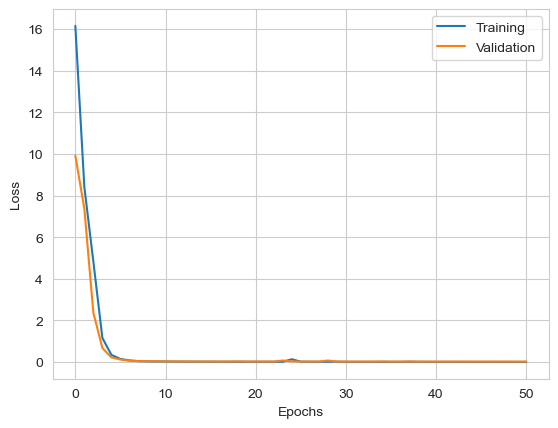

In [13]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.show()

## Evaluate the model

In [14]:
s0_test = np.zeros((1000, n_s))
c0_test = np.zeros((1000, n_s))
y_pred = model.predict([Xoh_test, s0_test, c0_test], verbose=0)
y_pred = np.argmax(y_pred, axis=-1)
y_pred_ = []

for i in np.swapaxes(y_pred, 0, 1):
    date = [inv_machine_vocab[j] for j in i]
    y_pred_.append(''.join(date))

X_test, y_test = zip(*dataset_test)
is_correct_prediction = [True if i == j else False for i, j in zip(y_test, y_pred_)]
print(f"Test accuracy = {100 * (sum(is_correct_prediction) / len(is_correct_prediction)):.2f}%")

Test accuracy = 99.80%


Show some mislabelled examples:

In [15]:
indexes = np.where([not x for x in is_correct_prediction])[0]

for i in indexes[:5]:
    print("\nSource date:", X_test[i])
    print("True date:", y_test[i])
    print("Predicted date:", y_pred_[i])


Source date: 29 december 2004
True date: 2003-12-29
Predicted date: 2004-12-29

Source date: 31 dec 2014
True date: 2013-12-31
Predicted date: 2014-12-31
